# Introduction

- **Workflow** - A steps to accomplish a given data engineering task.
- **Airflow** - used to create own data engineering workflows using **Directed Acyclic Graphs** (DAGs).
    - Can be accessed through CLI, or API.

In [ ]:

#* How to define a DAG
etl_dag = DAG(
    dag_id='etl_pipeline',
    default_args={"Start_date":"2025-08-07"}
)

#* How to run using shell
# airflow tasks test <dag_id> <task_id> <execution_date>

# Airflow DAGs

Has the following:

- **Directed** - Inherent flow representing dependencies between components.
- **Acyclic** - Does not loop/cycle/repeat
- **Graph** - Actual set of components

Used by: Airflow, Apache Spark, dbt.

- Made up of components (**tasks**) to be executed such as operators, sensors, etc.
- Contain dependencies implied explicitly or implicitly.

In [ ]:
from airflow import DAG
from datetime import datetime

default_arguments={
    'owner':'Toni',
    'email':'tonicastanares11@gmail.com',
    'start_date': datetime(2025,1,13),
}

with DAG('etl_workflow',default_args=default_arguments) as etl_dag:

# Airflow Operators

- Represents a single task in Airflow.
- Run independently
- Generally do not share information

For a list of operators, see [documentation](https://airflow.apache.org/docs/apache-airflow/stable/core-concepts/operators.html).

In [ ]:
from airflow.operators.bash import BashOperator

with DAG(dag_id="test_dag", default_args={"start_date": "2024-01-01"}) as analytics_dag:
    # Define the BashOperator 
    cleanup = BashOperator(
        task_id='cleanup_task',
        # Define the bash_command
        bash_command='cleanup.sh',
    )
    
    # Define a second operator to run the `consolidate_data.sh` script
    consolidate = BashOperator(
        task_id='consolidate_task',
        bash_command='consolidate_data.sh'
        )

    # Define a final operator to execute the `push_data.sh` script
    push_data = BashOperator(
        task_id='pushdata_task',
        bash_command='push_data.sh'
        )


In [ ]:
from airflow.operators.python import PythonOperator

def pull_file(URL, savepath):
    r = requests.get(URL)
    with open(savepath, 'wb') as f:
        f.write(r.content)   
    # Use the print method for logging
    print(f"File pulled from {URL} and saved to {savepath}")

from airflow.operators.python import PythonOperator

# Create the task
pull_file_task = PythonOperator(
    task_id='pull_file',
    # Add the callable
    python_callable=pull_file,
    # Define the arguments
    op_kwargs={'URL':'http://dataserver/sales.json', 'savepath':'latestsales.json'}
)

# Airflow Tasks

- Instance of an operator, assigned usually to a variable in Python.

## Task Dependencies
- Given order of task. Not required, but usually presnet.
- Defined by bithshift operators
    - \>\> - upstream operator (before)
    - \<\< - downstream operator (after)

In [ ]:
# Define a new pull_sales task
pull_sales = BashOperator(
    task_id='pullsales_task',
    bash_command='wget https://salestracking/latestinfo?json'
)

# Set pull_sales to run prior to cleanup
pull_sales >> cleanup

# Configure consolidate to run after cleanup
cleanup >> consolidate

# Set push_data to run last
push_data << consolidate

# Airflow Scheduling

## DAG Runs
- A specific instance of a worflow at a point in time.
- Can be run manually or via `schedule_interval`
- Maintain state for each workflow and tasks within
    - `running`
    - `failed`
    - `success`

## Airflow scheduler presets

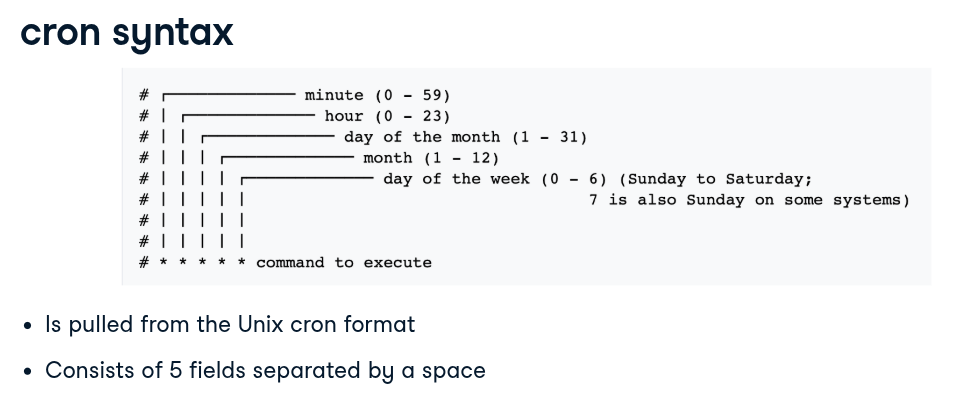
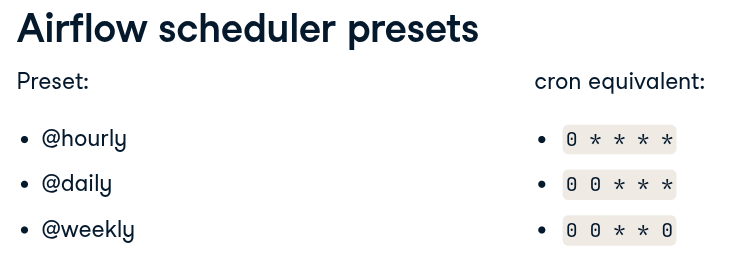

## Example code

In [ ]:
from datetime import timedelta
# Update the scheduling arguments as defined
default_args = {
  'owner': 'Engineering',
  'start_date': datetime(2023, 11, 1),
  'email': ['airflowresults@datacamp.com'],
  'email_on_failure': False,
  'email_on_retry': False,
  'retries': 3,
  'retry_delay': timedelta(minutes=20) 
}

# Update to run every 12:30 PM on Wednesday
dag = DAG('update_dataflows', default_args=default_args, schedule_interval='30 12 * * 3')

# Airflow Sensors

- An operator that waits for a certain condition to be true.
    - Creation of a file
    - Uplaod of a database record
    - Responses from web request
- Can define how to check for the condition to be true
- Are assigned to tasks

In [ ]:
from airflow import DAG
from airflow.operators.bash import BashOperator
from airflow.operators.python import PythonOperator
from airflow.providers.http.operators.http import SimpleHttpOperator
from airflow.sensors.filesystem import FileSensor

dag = DAG(
   dag_id = 'update_state',
   default_args={"start_date": "2023-10-01"}
)

#* Sensor
precheck = FileSensor(
   task_id='check_for_datafile',
   filepath='salesdata_ready.csv',
   dag=dag)

part1 = BashOperator(
   task_id='generate_random_number',
   bash_command='echo $RANDOM',
   dag=dag
)

import sys
def python_version():
   return sys.version

part2 = PythonOperator(
   task_id='get_python_version',
   python_callable=python_version,
   dag=dag)
   
part3 = SimpleHttpOperator(
   task_id='query_server_for_external_ip',
   endpoint='https://api.ipify.org',
   method='GET',
   dag=dag)
   
precheck >> part3 >> part2


# Airflow Executors

- Runs tasks. Different executors handle running the tasks differently.
- To see examples and all types, see [documentation](https://airflow.apache.org/docs/apache-airflow/stable/core-concepts/executor/index.html).
- Details about the executor is found in `airflow.cfg` inside the `airflow` directory.
- Use `grep` to extract `num_runs`

In [ ]:
precheck = FileSensor(
    task_id='check_for_datafile',
    filepath='salesdata_ready.csv',
    start_date=datetime(2024,1,20),
    mode='poke', #change to reschedule
    dag=report_dag
)

# poke - runs task repeatedly
# reschedule - Give up task slot and try again later


# Debugging

- Check if the scheduler is running: `airflow scheduler`.
- At least one `schedule_interval` hasn't passed --> Modify the attributes to meet your requirements.
- Check directory for `workspaces/dags` and `airflow/airflow.cfg` if DAGs won't load.
- Run `airflow dags list-import-errors` for checking importing error

# SLAs and Reporting

- **SLA** in Ariflow is the amount of time a task or a DAG should require to run.

In [ ]:
# Import the timedelta object
from datetime import timedelta

# Create the dictionary entry
default_args = {
  'start_date': datetime(2024, 1, 20),
  'sla': timedelta(minutes=30)
}

# Add to the DAG
test_dag = DAG('test_workflow', default_args=default_args, schedule_interval=None)

In [ ]:
from airflow import DAG
from airflow.operators.bash import BashOperator
from airflow.sensors.filesystem import FileSensor
from datetime import datetime

default_args={
    'email': ['airflowalerts@datacamp.com','airflowadmin@datacamp.com'],
    'email_on_failure': True,
    'email_on_success': True
}

report_dag = DAG(
    dag_id = 'execute_report',
    schedule_interval = "0 0 * * *",
    default_args=default_args
)

precheck = FileSensor(
    task_id='check_for_datafile',
    filepath='salesdata_ready.csv',
    start_date=datetime(2023,2,20),
    mode='reschedule',
    dag=report_dag)

generate_report_task = BashOperator(
    task_id='generate_report',
    bash_command='generate_report.sh',
    start_date=datetime(2023,2,20),
    dag=report_dag
)

precheck >> generate_report_task


# Working with Templates

- **Templates** allow substituting information during a DAG run.
- **Created using the `Jinja` templating language
- Provide flexibility in defining tasks

In [ ]:
from airflow import DAG
from airflow.operators.bash import BashOperator
from datetime import datetime

default_args = {
  'start_date': datetime(2023, 4, 15),
}

cleandata_dag = DAG('cleandata',
                    default_args=default_args,
                    schedule_interval='@daily')

# Create a templated command to execute
# 'bash cleandata.sh datestring'
templated_command = """
    bash cleandata.sh {{ds_nodash}}
"""

# Modify clean_task to use the templated command
clean_task = BashOperator(task_id='cleandata_task',
                          bash_command=templated_command,
                          dag=cleandata_dag)


In [ ]:
from airflow import DAG
from airflow.operators.bash import BashOperator
from datetime import datetime

default_args = {
  'start_date': datetime(2023, 4, 15),
}

cleandata_dag = DAG('cleandata',
                    default_args=default_args,
                    schedule_interval='@daily')

# Modify the templated command to handle a
# second argument called filename.
templated_command = """
  bash cleandata.sh {{ ds_nodash }} {{params.filename}}
"""

# Modify clean_task to pass the new argument
clean_task = BashOperator(task_id='cleandata_task',
                          bash_command=templated_command,
                          params={'filename': 'salesdata.txt'},
                          dag=cleandata_dag)

# Create a new BashOperator clean_task2
clean_task2 = BashOperator(task_id='cleandata_task2',
                           bash_command=templated_command,
                           params={'filename': 'supportdata.txt'},
                           dag=cleandata_dag)
                           
# Set the operator dependencies
clean_task >> clean_task2


In [ ]:
from airflow import DAG
from airflow.operators.bash import BashOperator
from datetime import datetime

filelist = [f'file{x}.txt' for x in range(30)]

default_args = {
  'start_date': datetime(2020, 4, 15),
}

cleandata_dag = DAG('cleandata',
                    default_args=default_args,
                    schedule_interval='@daily')

# Modify the template to handle multiple files in a 
# single run.
templated_command = """
  <% for filename in params.filenames %>
  bash cleandata.sh {{ ds_nodash }} {{ filename }};
  <% endfor %>
"""

# Modify clean_task to use the templated command
clean_task = BashOperator(task_id='cleandata_task',
                          bash_command=templated_command,
                          params={'filenames': filelist},
                          dag=cleandata_dag)


In [ ]:
from airflow import DAG
from airflow.operators.email import EmailOperator
from datetime import datetime

# Create the string representing the html email content
html_email_str = """
Date: {{ ds }}
Username: {{ params.username }}
"""

email_dag = DAG('template_email_test',
                default_args={'start_date': datetime(2023, 4, 15)},
                schedule_interval='@weekly')
                
email_task = EmailOperator(task_id='email_task',
                           to='testuser@datacamp.com',
                           subject="{{ macros.uuid.uuid4() }}",
                           html_content=html_email_str,
                           params={'username': 'testemailuser'},
                           dag=email_dag)


# Branching

- Provides conditional logic
- `from airflow.operators.python import BranchPythonOperator` 
- Takes a `python_callable` to return next task id (or list of ids) to follow.

In [ ]:
# Create a function to determine if years are different
def year_check(**kwargs):
    current_year = int(kwargs['ds_nodash'][0:4])
    previous_year = int(kwargs['prev_ds_nodash'][0:4])
    if current_year == previous_year:
        return 'current_year_task'
    else:
        return 'new_year_task'

# Define the BranchPythonOperator
branch_task = BranchPythonOperator(task_id='branch_task', dag=branch_dag,
                                   python_callable=year_check, provide_context=True)
# Define the dependencies
branch_task >> current_year_task
branch_task >> new_year_task

# Creating a Production Pipeline

### `process.py`

In [ ]:
from datetime import date

def process_data(**kwargs):

    file = open("/home/repl/workspace/processed_data-" + kwargs['ds'] + ".tmp", "w")
    
    file.write(f"Data processed on {date.today()}")
    
    file.close()

### `pipeline.py`

In [ ]:
from airflow import DAG
from airflow.sensors.filesystem import FileSensor
from airflow.operators.bash import BashOperator
from airflow.operators.python import PythonOperator
from dags.process import process_data
from datetime import timedelta, datetime

# Update the default arguments and apply them to the DAG
default_args = {
  'start_date': datetime(2023,1,1),
  'sla':timedelta(minutes=90)
}

dag = DAG(dag_id='etl_update', default_args=default_args)

sensor = FileSensor(task_id='sense_file', 
                    filepath='/home/repl/workspace/startprocess.txt',
                    poke_interval=45,
                    dag=dag)

bash_task = BashOperator(task_id='cleanup_tempfiles', 
                         bash_command='rm -f /home/repl/*.tmp',
                         dag=dag)

python_task = PythonOperator(task_id='run_processing', 
                             python_callable=process_data,
                             provide_context=True,
                             dag=dag)

sensor >> bash_task >> python_task


### `pipeline_2.py`

- With added **branching**

In [ ]:
from airflow import DAG
from airflow.sensors.filesystem import FileSensor
from airflow.operators.bash import BashOperator
from airflow.operators.python import PythonOperator
from airflow.operators.python import BranchPythonOperator
from airflow.operators.empty import EmptyOperator
from airflow.operators.email import EmailOperator
from dags.process import process_data
from datetime import datetime, timedelta

# Update the default arguments and apply them to the DAG.

default_args = {
  'start_date': datetime(2023,1,1),
  'sla': timedelta(minutes=90)
}
    
dag = DAG(dag_id='etl_update', default_args=default_args)

sensor = FileSensor(task_id='sense_file', 
                    filepath='/home/repl/workspace/startprocess.txt',
                    poke_interval=45,
                    dag=dag)

bash_task = BashOperator(task_id='cleanup_tempfiles', 
                         bash_command='rm -f /home/repl/*.tmp',
                         dag=dag)

python_task = PythonOperator(task_id='run_processing', 
                             python_callable=process_data,
                             provide_context=True,
                             dag=dag)

email_subject="""
  Email report for {{ params.department }} on {{ ds_nodash }}
"""

email_report_task = EmailOperator(task_id='email_report_task',
                                  to='sales@mycompany.com',
                                  subject=email_subject,
                                  html_content='',
                                  params={'department': 'Data subscription services'},
                                  dag=dag)

no_email_task = EmptyOperator(task_id='no_email_task', dag=dag)

def check_weekend(**kwargs):
    dt = datetime.strptime(kwargs['execution_date'],"%Y-%m-%d")
    # If dt.weekday() is 0-4, it's Monday - Friday. If 5 or 6, it's Sat / Sun.
    if (dt.weekday() < 5):
        return 'email_report_task'
    else:
        return 'no_email_task'
    
branch_task = BranchPythonOperator(task_id='check_if_weekend',
                                   python_callable=check_weekend,
                                   provide_context=True,                                
                                   dag=dag)

sensor >> bash_task >> python_task

python_task >> branch_task >> [email_report_task, no_email_task]